<a href="https://colab.research.google.com/github/Will-Trinh/CECS456/blob/main/456project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Install the Kaggle library
!pip install -q kaggle

# 2. Upload your kaggle.json file
# Run this cell, then click "Choose Files" and select your kaggle.json
from google.colab import files
print("Upload your kaggle.json file now:")
files.upload()

# 3. Move the key to the correct location and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download the Animals-10 dataset directly from Kaggle
print("Downloading dataset...")
!kaggle datasets download -d alessiocorrado99/animals10

# 5. Unzip the data into 'dataset_root'
print("Unzipping...")
!unzip -q animals10.zip -d dataset_root

print("Data successfully loaded from Kaggle!")

Upload your kaggle.json file now:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 89% 523M/586M [00:00<00:00, 1.81GB/s]
100% 586M/586M [00:00<00:00, 1.79GB/s]
Unzipping...
Data successfully loaded from Kaggle!


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define setup variables
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
DATA_DIR = "dataset_root/raw-img" # The unzipped folder name usually contains 'raw-img'

# Load Training Data (80% split)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load Validation Data (20% split)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Print class names for your report
class_names = train_ds.class_names
print(f"Classes found: {class_names}")

# Performance optimization (keeps data in memory)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Classes found: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [3]:
# Build the CNN Model
model = keras.Sequential([
    # Explicit Input Layer
    keras.Input(shape=(128, 128, 3)),

    # Rescaling (Normalizing pixel values 0-1)
    layers.Rescaling(1./255),

    # Convolutional Block 1
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolutional Block 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolutional Block 3
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Flatten & Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Critical for "Analysis" points (reduces overfitting)
    layers.Dense(len(class_names), activation='softmax') # Output layer
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,970 (16.36 MB)

 Trainable params: 4,288,970 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.2641 - loss: 2.0762 - val_accuracy: 0.4560 - val_loss: 1.5576
Epoch 2/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.4467 - loss: 1.6044 - val_accuracy: 0.5417 - val_loss: 1.3292
Epoch 3/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5298 - loss: 1.3627 - val_accuracy: 0.6187 - val_loss: 1.1364
Epoch 4/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5806 - loss: 1.2075 - val_accuracy: 0.6367 - val_loss: 1.0534
Epoch 5/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6379 - loss: 1.0543 - val_accuracy: 0.6565 - val_loss: 0.9922
Epoch 6/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6802 - loss: 0.9118 - val_accuracy: 0.6684 - val_loss: 0.9915
Epoch 7/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7359 - loss: 0.7795 - val_accuracy: 0.6825 - val_loss: 0.9569
Epoch 8/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7581 - loss: 0.6913 - 

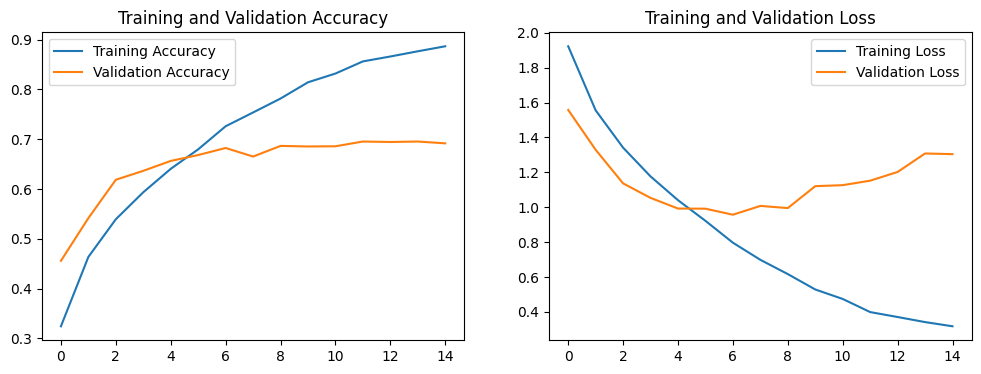

In [5]:
# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Generating predictions... this may take a moment.
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


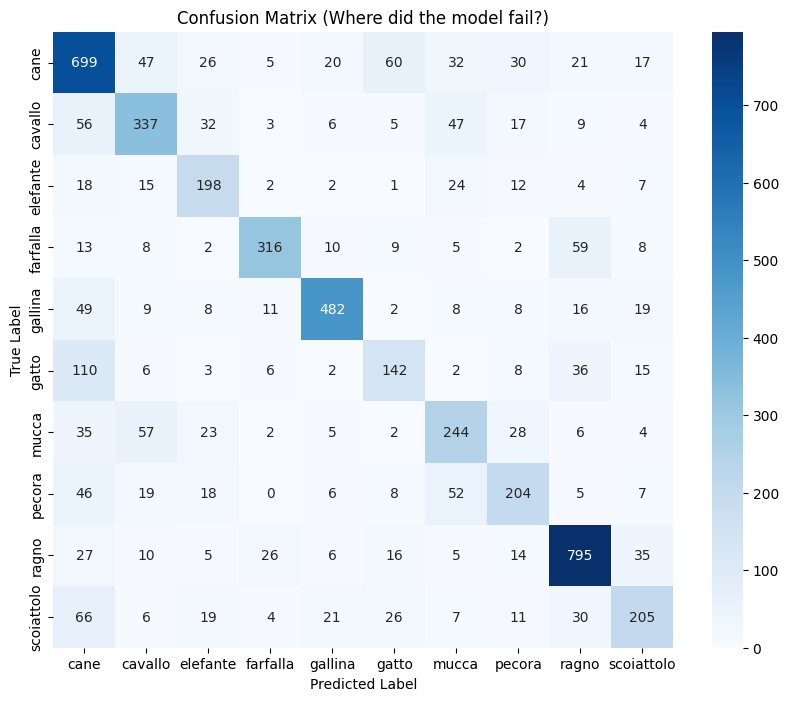

              precision    recall  f1-score   support

        cane       0.62      0.73      0.67       957
     cavallo       0.66      0.65      0.65       516
    elefante       0.59      0.70      0.64       283
    farfalla       0.84      0.73      0.78       432
     gallina       0.86      0.79      0.82       612
       gatto       0.52      0.43      0.47       330
       mucca       0.57      0.60      0.59       406
      pecora       0.61      0.56      0.58       365
       ragno       0.81      0.85      0.83       939
  scoiattolo       0.64      0.52      0.57       395

    accuracy                           0.69      5235
   macro avg       0.67      0.66      0.66      5235
weighted avg       0.69      0.69      0.69      5235



In [6]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get Predictions for the Validation Set
print("Generating predictions... this may take a moment.")
val_images = []
val_labels = []

# Loop through the validation set to get all images and true labels
for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Predict
predictions = model.predict(val_images)
predicted_labels = np.argmax(predictions, axis=1)

# 2. Plot Confusion Matrix
cm = confusion_matrix(val_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Where did the model fail?)')
plt.show()

# 3. Print Classification Report (Precision/Recall per animal)
print(classification_report(val_labels, predicted_labels, target_names=class_names))